# Binned $\chi^2$ fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Define fit model

In [2]:
tmax = 100

# Exponential decay + uniform background

def myfun(x,par):

    # decay time
    
    tdec = par[0]
    
    # Decay normalisation
    
    ndec = par[1]

    # Background normalisation
    
    nbg = par[2]
    
    # Exponential probability distribution
    
    val = ndec/tdec * np.exp(-x/tdec)

    # Add constant term
    
    val += nbg 

    return val

# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,3))

    # decay time
    
    tdec = par[0]
    
    # Decay normalisation
    
    ndec = par[1]

    # Background normalisation
    
    nbg = par[2]
    
    # Exponential probability distribution
    
    val = 1/tdec * np.exp(-x/tdec)

    der[:,0] = ndec*val*(x-tdec)/tdec/tdec
    
    der[:,1] = val
    
    der[:,2] =  1.
    
    val = ndec*val + nbg

    return val,der

# myfunder(np.array([0.,1.,2.,3.,4.,5.,6.,7.]),np.array([2.2,1000.,10.]))

### (2) Read input data

In [3]:
# Nevt = 100
# infile = "http://hep.fuw.edu.pl/u/zarnecki/saed23/11_example_data_"+str(Nevt)+".dat"

# Old data (as shown in lecture slides)

Nevt = 10000
infile = "http://hep.fuw.edu.pl/u/zarnecki/saed22/10_example_data_"+str(Nevt)+".dat"


ttab = np.loadtxt(infile)

In [4]:
# Create  histogram

tmax = 100.
Nbin = 100

counts, bins = np.histogram(ttab,range=[0,tmax],bins=Nbin)

xvec = bins[:Nbin] + bins[1]/2.
yvec = counts

# Poisson errors, add 1 to take bins with zero events into account

svec = np.sqrt(yvec+1)
s2vec = svec*svec


### (3) Iterative fit

In [5]:
# Number of function parameters to consider  (fixed for this model)

Nfun = 3

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 2.
parini[1] = 2.*Nevt
parini[2] = 0.01*Nevt

# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

chi2ini = np.sum((yvec-fini)**2/s2vec)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [2.e+00 2.e+04 1.e+02]
  chi^2 =  49553.969   chi^2/N = 495.53969 


In [6]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.001   # Required precision (distance from minimum)

chi2min = chi2ini
parmin = parini

par = parini
Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    dyvec = yvec-fval
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*dyvec/s2vec)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
#        C[l,l] *= 1 + lam
        C[l,l] += lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    chi2new = np.sum((yvec-fnew)**2/s2vec)

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    if chi2new < chi2min :
        print("\nIteration step ",Nit," with lambda = ",lam)
        print(" ",parnew)
        print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2new,chi2new/(xvec.size-Nfun)))
        print("  distance to minimum: ",dist)
    
        lam /= 10
        chi2min = chi2new
        par = parnew
    else:
        lam *= 10



Iteration step  1  with lambda =  0.01
  [2.26747602e+00 1.98597723e+04 1.49824345e+01]
  chi^2 =  16580.043   chi^2/N = 170.92827 
  distance to minimum:  33166.298900949776

Iteration step  2  with lambda =  0.001
  [2.31250803e+00 1.86123119e+04 1.48575197e+01]
  chi^2 =  13262.159   chi^2/N = 136.72329 
  distance to minimum:  1755.1927443985703

Iteration step  3  with lambda =  0.0001
  [2.29961473e+00 1.29024621e+04 1.68611500e+01]
  chi^2 =  2880.168   chi^2/N = 29.69245 
  distance to minimum:  7140.0560360355485

Iteration step  4  with lambda =  1e-05
  [2.26460395e+00 8.45668366e+03 1.84476297e+01]
  chi^2 =   144.241   chi^2/N =  1.48702 
  distance to minimum:  2553.304852306413

Iteration step  5  with lambda =  1.0000000000000002e-06
  [2.24084934e+00 8.08477085e+03 1.85787712e+01]
  chi^2 =   127.088   chi^2/N =  1.31019 
  distance to minimum:  17.33759072989749

Iteration step  6  with lambda =  1.0000000000000002e-07
  [2.23940586e+00 8.08166158e+03 1.85801409e+01]

In [7]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     2.239  +/-  0.029 
  8081.656  +/- 91.865 
    18.580  +/-  0.476 

 Correlation matrix

[ 1.     0.05  -0.131]
[ 0.05   1.    -0.067]
[-0.131 -0.067  1.   ]

 chi^2 =   127.085   chi^2/Ndf =  1.31015 


### (4) Draw data and fit

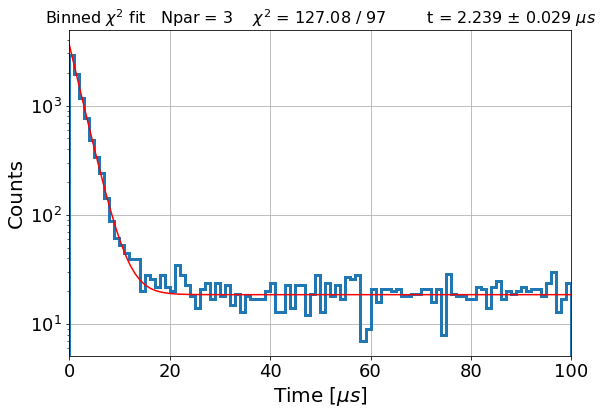

In [8]:
Nf = 100
xfun = np.linspace(0.,tmax,Nf)
yfun = myfun(xfun,par)

plt.figure(figsize=(9, 6))

plt.hist(ttab,range=[0,tmax],bins=Nbin,log=True, histtype='step',linewidth=3)
plt.plot(xfun,yfun,'r-')
plt.xlim([0,tmax])

plt.title('Binned $\chi^2$ fit   Npar = {}    $\chi^2$ = {:.2f} / {}        t = {:.3f} $\pm$ {:.3f} $\mu s$'.format(Nfun,chi2,xvec.size-Nfun,par[0],epar[0]),size=16)
plt.ylabel('Counts',size=20)
plt.xlabel('Time [$\mu s$]',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '11_binned_fit_'+str(Nevt)+'_'+str(Nbin)+'.png'
plt.savefig(fname)